### SAME as previous program but for the new OMROM log format: This very simple notebook will take a blood pressure reading log (the provided example data is produced by an OMRON Smart X reader), allocate the readings to three sections of the day (AM, MID and PM) and draw a boxplot to perform a first rough estimate about the presence of a trend.

With the data provided for instance you can form the hypothesis that the pressure in the afternoon/evening is better that in the morning/central part of the day and for instance you could act shifting the time of your pressure medication from the evening to the morning to better control the daily values.

Import needed libraries

In [1]:
# One ring to handle numbers
import pandas as pd
import scipy.stats as stats
# One ring to handle time
import datetime as dt
from datetime import date
import time
# One ring to draw reality
import seaborn as sns
import matplotlib.pyplot as plt
# and One ring to rule them all ;)
# from matplotlib.dates import date2num

Set the (arbitrary) limits to divide the day in an AM, MID(day) and PM areas and the name of data file

In [2]:
AM_LIMIT = 10
PM_LIMIT = 16
LOGNAME = 'data/new_bp_log.csv'
# LOGNAME = '../input/blood-pressure-readings/bp_log.csv' # on Kaggle
# https://www.kaggle.com/rjalexander/blood-pressure-circadian

Define a function to generate a "partofday" categorical label based on the hour of the blood pressure reading and the limits we set above

In [3]:
def partofday(hour):
    if hour <= AM_LIMIT:
        return 'AM'
    elif hour > AM_LIMIT and hour <= PM_LIMIT:
        return 'MID'
    else:
        return 'PM'

Read and take a peek at the data as read in a dataframe

In [6]:
df = pd.read_csv(LOGNAME)

In [7]:
# recreate a Measurement Date text field field like in the old log format to reuse older code
df["Measurement Date"] = df["Date"] + " " + df["Time"]
# also rename the systolic (SYS) and diastolic (DIA) and pulse (Pulse) columns with the old log format names
df.rename(columns = {'Systolic (mmHg)':'SYS', 'Diastolic (mmHg)':'DIA', 'Pulse (bpm)':'Pulse'}, inplace = True)

,Date,Time,SYS,DIA,Pulse,Irregular heartbeat detected,Body Movement,Cuff wrap guide,Positioning Indicator,Measurement Mode,Possible Afib,Device,Notes,Measurement Date
0,28 Jun 2022,10:02,107,69,72,,,Not OK,,,,X7 Smart,-,28 Jun 2022 10:02
1,28 Jun 2022,09:51,109,65,73,,,,,,,X7 Smart,-,28 Jun 2022 09:51
2,27 Jun 2022,12:19,104,63,67,,,,,,,X7 Smart,-,27 Jun 2022 12:19
3,27 Jun 2022,11:02,95,62,70,,,,,,,X7 Smart,-,27 Jun 2022 11:02
4,27 Jun 2022,10:43,83,56,69,,,,,,,X7 Smart,-,27 Jun 2022 10:43


Add a new "partofday" categorical new column in the dataframe

In [9]:
df['partofday'] = df.apply(lambda row: partofday(pd.to_datetime(row['Measurement Date']).hour), axis=1)
df.head()

,Date,Time,SYS,DIA,Pulse,Irregular heartbeat detected,Body Movement,Cuff wrap guide,Positioning Indicator,Measurement Mode,Possible Afib,Device,Notes,Measurement Date,partofday
0,28 Jun 2022,10:02,107,69,72,,,Not OK,,,,X7 Smart,-,28 Jun 2022 10:02,AM
1,28 Jun 2022,09:51,109,65,73,,,,,,,X7 Smart,-,28 Jun 2022 09:51,AM
2,27 Jun 2022,12:19,104,63,67,,,,,,,X7 Smart,-,27 Jun 2022 12:19,MID
3,27 Jun 2022,11:02,95,62,70,,,,,,,X7 Smart,-,27 Jun 2022 11:02,MID
4,27 Jun 2022,10:43,83,56,69,,,,,,,X7 Smart,-,27 Jun 2022 10:43,AM


Now plot the SYS(tolic) and then the DIA(stolic) pressure values divided in the three sections of the day

In [53]:
sns.set_theme(style="whitegrid")

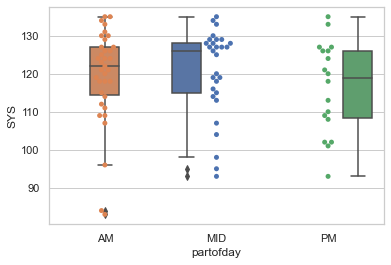

In [54]:
ax = sns.boxplot(x=df["partofday"], y=df["SYS"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax = sns.swarmplot(x=df["partofday"], y=df["SYS"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax.legend_.remove()

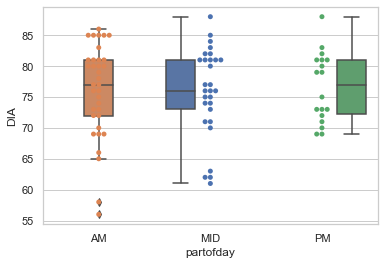

In [55]:
ax = sns.boxplot(x=df["partofday"], y=df["DIA"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax = sns.swarmplot(x=df["partofday"], y=df["DIA"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax.legend_.remove()

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and PM

In [56]:
stats.ttest_ind(df['SYS'][df['partofday'] == 'AM'], df['SYS'][df['partofday'] == 'PM'])

Ttest_indResult(statistic=0.845424660294705, pvalue=0.40182280685361227)

In [57]:
stats.ttest_ind(df['DIA'][df['partofday'] == 'AM'], df['DIA'][df['partofday'] == 'PM'])

Ttest_indResult(statistic=-0.27555276498320835, pvalue=0.7840050089402)

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and MIDday

In [58]:
stats.ttest_ind(df['SYS'][df['partofday'] == 'AM'], df['SYS'][df['partofday'] == 'MID'])

Ttest_indResult(statistic=-0.3350853740805134, pvalue=0.7386917916887347)

In [59]:
stats.ttest_ind(df['DIA'][df['partofday'] == 'AM'], df['DIA'][df['partofday'] == 'MID'])

Ttest_indResult(statistic=0.06822278876783652, pvalue=0.9458278331944387)

### Conclusion: 

### Let's now plot the BP values and see what's the temporal trend in time

### Add an elapsed_seconds column converting the datetime value to number of seconds from the oldest one


In [65]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['unix'] = df['datetime'].astype('int64')/1e9 # if I needed seconds from Unix epoch
df['elapsed_seconds'] = (df['datetime']-df['datetime'].min()).dt.total_seconds()

Now plot a scatterplot with a linear regression fit. To do so as the scattterplot does not accept a datetime timestamp as the x values, I am using the epoch (seconds from 01-jan-1970) contained in the "date_ordinal" column

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_56829/3663205825.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


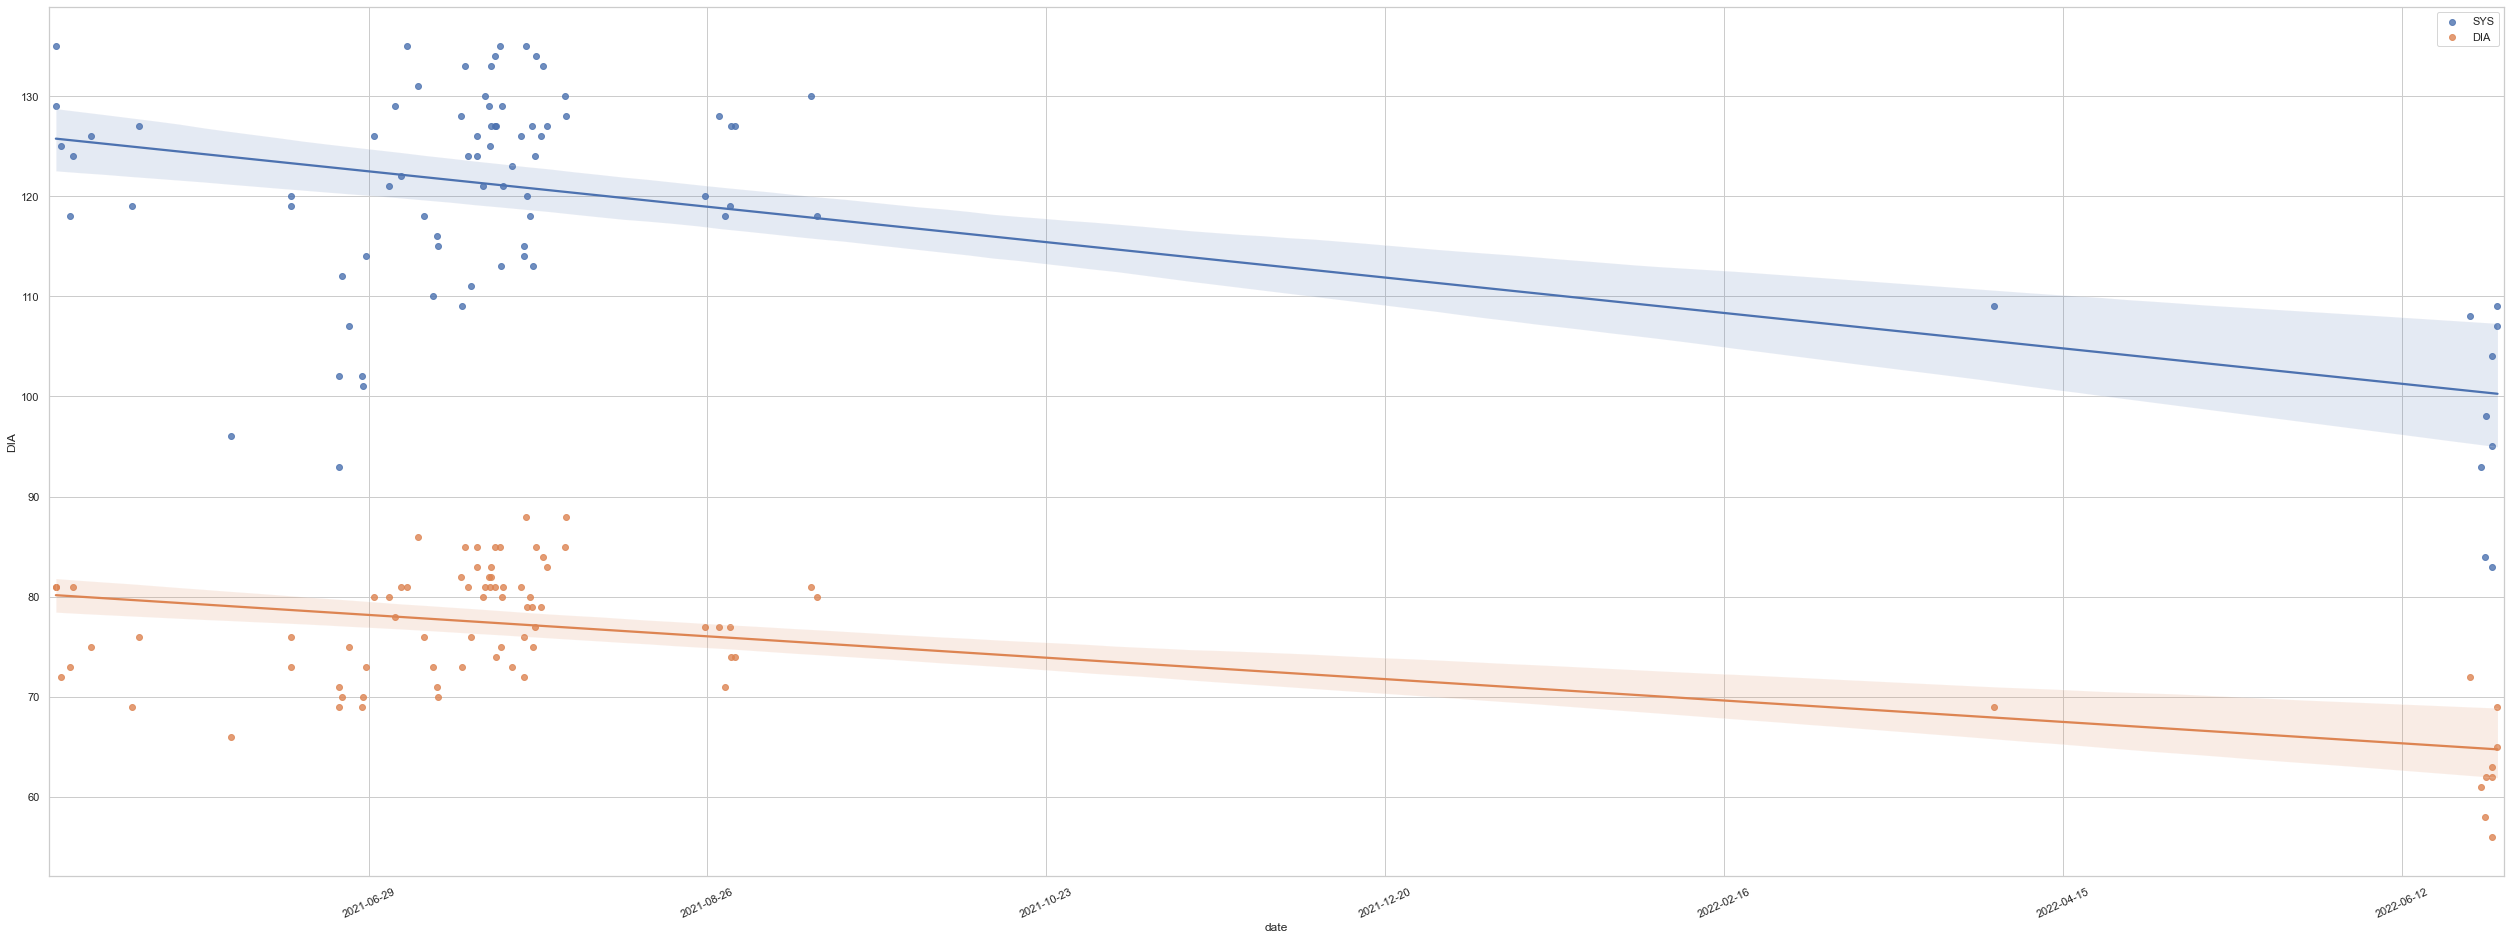

In [67]:
plt.figure(figsize=(44,16))
ax = sns.regplot(x="unix", y="SYS", data=df, label="SYS")
ax = sns.regplot(x="unix", y="DIA", data=df, label="DIA")
# create some whitespace horizontally around the plot values
ax.set_xlim(df['unix'].min() - 100000, df['unix'].max() + 100000)
# now convert the epoch values back to a YYYY-MM-DD string for the x labels
# localtime converts the epoch into a datetime object abd strftime converts it into a string
new_labels = [time.strftime('%Y-%m-%d',time.localtime(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
# set some visuals
ax.set_xlabel('date')
plt.xticks(rotation=25)
plt.legend()
plt.show()

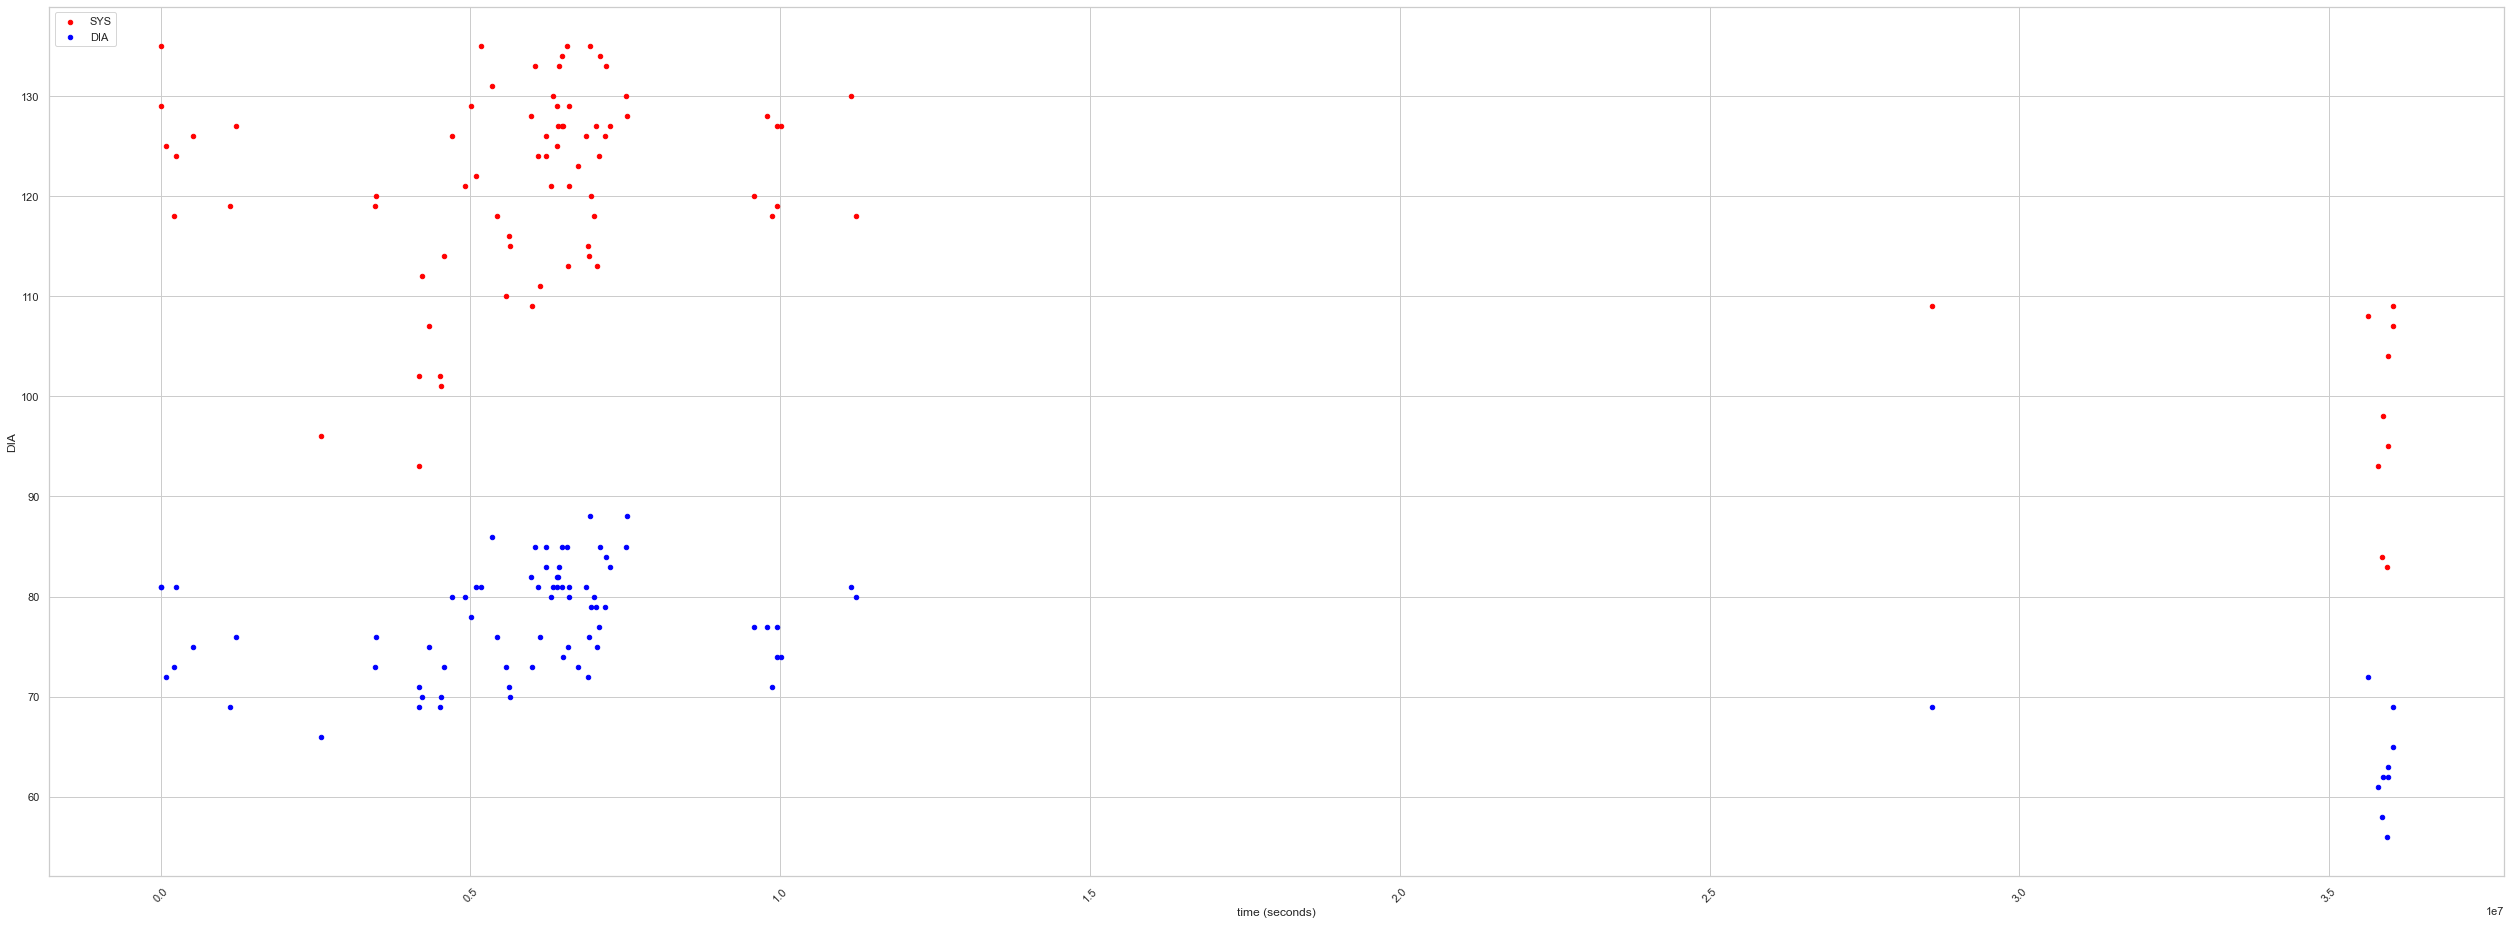

In [51]:
fig, ax = plt.subplots(figsize=(44,16))

ax1 = df.plot.scatter(x='elapsed_seconds', y='SYS', color='red', grid=True, label='SYS', ax=ax)
ax1 = df.plot.scatter(x='elapsed_seconds', y='DIA', color='blue', grid=True, label='DIA', ax=ax)
plt.legend()
plt.legend(loc='upper left')
plt.xticks(rotation=45)
ax1.set_xlabel('time (seconds)')
plt.show()